<h1> Otimização - COS360 2018.2</h1>
<h2> Pedro Maciel Xavier e Ana Paula da Silva Falcão </h2>

$$
\begin{align}
&\displaystyle \min \ f(x)\\
& \text{s. a.}\  x \in \Omega\\
&\\
f(x) &= -30x_1 - 10x_2 - 40x_3 - 12x_4\\
\Omega &:= \mathbb{R}^4 \cap \underbrace{\{33x_1 + 14x_2 + 47x_3 + 11x_4 \le 59\}}_{\Omega_1} \cap \underbrace{\{0 \le x \le 1\}}_{\Omega_2} \cap \underbrace{\{x_i (1 - x_i) =
0 \ \forall i \in \{1, \dots , 4\}\}}_{\Omega_3}\\
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline
n = 4
c = np.array([-30, -10, -40, -12])

def f(x):
    return c @ x

o = np.array([33,14, 47,11])
omega = [
    (lambda x: (o @ x) <= 59),
    (lambda x: np.all((0 <= x) & (x <= 1))),
    (lambda x: np.all(x*(1-x) == 0))
]
def g(x):
    return all(om(x) for om in omega)

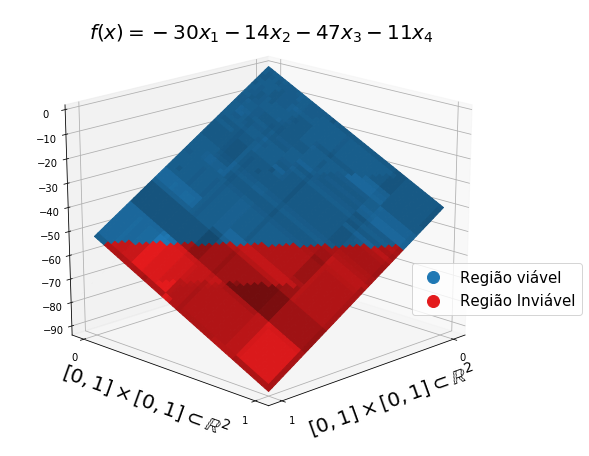

In [2]:
num = 1000
x1, x2, x3, x4 = [np.linspace(0,1,num=num) for _ in range(4)]
x = -30*x1 -10*x2
y = -40*x3 -12*x4
X,Y = np.meshgrid(x,y)

AX, AY = np.meshgrid(x1,x3)

rx = 33*x1 + 14*x2
ry = 47*x1 + 11*x4
RX, RY = np.meshgrid(rx,ry)

Z = X + Y
V = (RX + RY) <= 59
U = -4*(V)+5

fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20,45)
ax.plot_surface(AY, AX, Z, facecolors=cm.Paired(U), label= 'oi')
axis_lbl = r'$[0,1] \times [0,1] \subset \mathbb{R}^2$'
ax.set_xlabel(axis_lbl, fontsize=20)
ax.set_ylabel(axis_lbl, fontsize=20)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_zticks([-z for z in range(0,100,10)])
ax.set_title(r'$f(x) = -30x_1 - 14x_2 - 47x_3 - 11x_4$', fontsize=20)
ax.set_facecolor((1, 1, 1))
fake_line1 = mpl.lines.Line2D([0],[0], linestyle="none", c=cm.Paired(1), marker = 'o')
fake_line2 = mpl.lines.Line2D([0],[0], linestyle="none", c=cm.Paired(5), marker = 'o')
ax.legend([fake_line1,fake_line2], [u'Região viável','Região Inviável'], numpoints = 1, loc=(.8,.3), fontsize=15, markerscale=2)
plt.show()

Como as variáveis são binárias ($x \in \mathbb{Z}_2$) por conta da restrição $\Omega_3$, podemos resolver o problema simplesmente buscando entre as $2^4 = 16$ opções possíveis e vendo qual combinação de 0's e 1's tem a menor função objetivo $f(x)$.

In [3]:
X = [np.array(list(("{:b}".format(x)).zfill(n)),dtype=np.int32) for x in range(2**n)]
Y = list(filter(g, X))
Z = sorted(Y, key=f, reverse=True)
F = list(map(f,Z))
minf = min(F)

print(" x        f[x]")
for x,v in list(zip(Z,F)):
    print(x, "%3d"%v, end=" ")
    if v == minf: print("(min)", end="")
    print()

 x        f[x]
[0 0 0 0]   0 
[0 1 0 0] -10 
[0 0 0 1] -12 
[0 1 0 1] -22 
[1 0 0 0] -30 
[0 0 1 0] -40 
[1 1 0 0] -40 
[1 0 0 1] -42 
[0 0 1 1] -52 (min)
[1 1 0 1] -52 (min)


A função $f(x)$ não tem pontos críticos, uma vez que seu gradiente é $\nabla f(x) = (-30, -14, -47, -11)^T$, que nunca se anula e independe de $x$. Isso faz com que um método de penalização seja necessário para que se possa usar o método do gradiente para resolver o problema.

Uma penalização exterior possível seria construir $\phi(x,\rho) = f(x) + \rho P(x)$ onde $\displaystyle P(x) = \sum_{g \in G} \max\{0, g(x)\}^2 + \sum_{h \in H} h(x)^2$

A partir daí, calculamos o gradiente $\nabla_x \varPhi(x,\rho) = \nabla_x f(x) + \rho\nabla_xP(x)$:

Sabemos que 

$$
g_+(x) = \max\{0, g(x)\} = \begin{cases}
       0 &\text{se}_\ g(x) \le 0\\
       g(x) &\text{se}_\ g(x) > 0 \\
     \end{cases}
$$

Logo:

$$
\nabla g_+(x) = \nabla \max\{0, g(x)\} = \begin{cases}
       0 &\text{se}_\ g(x) \le 0\\
       \nabla g(x) &\text{se}_\ g(x) > 0 \\
     \end{cases}
$$

Assim,

$$ \displaystyle \nabla_x \varPhi(x,\rho)_{ext} = \nabla_x f(x) + \rho\nabla_xP(x) = \nabla_x f(x) + 2\, \rho \cdot \Big\{\sum_{g \in G} g_+(x) \cdot \nabla_x g_+(x) + \sum_{h \in H} h(x) \cdot \nabla_x h(x)\Big\}$$

Onde $G$ e $H$ são as restrições em desigualdade e igualdade, respectivamente.

Uma penalidade interior é obtida trocando $g_+(x)$ por $\displaystyle\frac{-1}{g(x)}$ e $g_+(x) \cdot \nabla g_+(x)$ por $\displaystyle\frac{1}{g(x)^2} \cdot \nabla g(x)$ e garantindo um coeficiente $\rho$ distinto para cada somatório, seguido do ajuste das constantes, ficando então:

$$ \displaystyle \nabla_x \varPhi(x,\rho)_{int} = \nabla_x f(x) + \rho\nabla_xP(x) = \nabla_x f(x) + \Big\{\rho_g\sum_{g \in G} \frac{1}{g(x)^2} \cdot \nabla g(x) + 2\,\rho_h \sum_{h \in H} h(x) \cdot \nabla_x h(x)\Big\}$$
     

In [4]:
# Derivada Parcial
def Dp(f,k,h=1e-7):
    def f_(x):
        y = np.zeros(len(x), dtype=np.complex128)
        y[:] = x[:]
        y[k] += 1j*h
        return f(y).imag/h
    return f_

# 
def grad(f, m, h=1e-7):
    return lambda x: np.array([Dp(f,k,h)(x) for k in range(m)])

In [36]:
def Phi_Ext(f, p, G=None, H=None): # Exterior
    if type(p) not in (tuple, list):
        p = (p,p)
    G = [] if G is None else G
    H = [] if H is None else H
    def _Phi_(x):
        y = f(x)
        z = sum([pow(max(0, g(x)),2) for g in G])
        w = sum([pow(h(x),2) for h in H])
        return y + p[0]*z + p[1]*w
    return _Phi_

def Phi_Int(f, p, G=None, H=None): # Interior
    if type(p) not in (tuple, list):
        p = (p,p)
    G = [] if G is None else G
    H = [] if H is None else H
    def _Phi_(x):
        y = f(x)
        z = sum([pow(-g(x),-1) for g in G])
        w = sum([pow(h(x),2) for h in H])
        return y + p[0]*z + p[1]*w
    return _Phi_

eps = 0.1
def Phi_Hyp(f, p, G=None, H=None): # Hiperbólica
    if type(p) not in (tuple, list):
        p = (p,p)
    G = [] if G is None else G
    H = [] if H is None else H
    def _Phi_(x):
        y = f(x)
        z = sum([np.sqrt(pow(g(x),2) + eps) for g in G])
        w = sum([pow(h(x),2) for h in H])
        return y + p[0]*z + p[1]*w
    return _Phi_

G = [
     lambda x : 59 - o@x, 
     lambda x: x[0],
     lambda x: 1-x[0],
     lambda x: x[1],
     lambda x: 1-x[1],
     lambda x: x[2],
     lambda x: 1-x[2],
     lambda x: x[3],
     lambda x: 1-x[3]
    ]


H = [
     lambda x : x[0]*(1-x[0]),
     lambda x : x[1]*(1-x[1]),
     lambda x : x[2]*(1-x[2]),
     lambda x : x[3]*(1-x[3])
    ]

def _grad_G(G):
    return [lambda x,g=g: grad(g, n)(x) if g(x) > 0 else 0 for g in G]

def _grad_H(H):
    return [lambda x,h=h: grad(h, n)(x) for h in H]

In [40]:
def armijo(f, Phi, x, d, gamma, eta):
    grad_f = grad(f,n)
    
    # coeficiente
    t = 1
    
    # nº de iterações
    j = 0
    
    u = Phi(x + t*d)
    v = (eta*t)*(grad_f(x)@d) + Phi(x)
    while u>v:
        t *= gamma
        u = Phi(x + t*d),
        v = (eta*t)*(grad_f(x)@d) + Phi(x)
        j += 1
    else:
        return t,j
    
def stop(x,y,j):
    return np.allclose(x, y, atol=1e-16) or j > 20
    
def gradiente(f, Phi, x, gamma=.8, eta=.25):
    # gradientes
    grad_f = grad(f,n)
    grad_Phi = grad(Phi,n)
    
    # nº de iterações
    j = 0
    
    y = float('inf')*np.ones(n)
    while not stop(x,y,j):
        d = - grad_Phi(x)
        t,_ = armijo(f, Phi, x, d, gamma, eta)
        y[:] = x[:]
        x[:] = x[:] + t*d
        j += 1
    else:
        return f(x),x, j
    
c = np.array([-30, -10, -40, -12])

def f(x):
    return c @ x

p = 10,1000
Phi = Phi_Ext(f, p, G, H)

In [41]:
x = np.array([.5,.5,.5,.5], dtype=np.float64)

In [42]:
ff, xx, k = gradiente(f, Phi, x)
print(ff,xx,np.round(xx),k)

-53.18734351220107 [1.00262876 0.99540382 0.0298915  0.99656522] [1. 1. 0. 1.] 8
